# Gradient Descent

**Prerequisites**

- Numpy
- Calculus
- Linear Algebra

**Outcomes**

- Understand the gradient descent algorithm for unconstrained optimization
- Implement gradient descent using analytical derivatives
- Understand finite difference methods of approximating derivatives
- Be introduced to tensorflow and the concept of autodifferentiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Nonlinear Optimization

- The class of nonlinear optimization problems is very broad
- The main objective:
$$\begin{align}
\min_x \quad & f(x) \\
\text{s.t.}\quad & c_E(x) = 0 \\
& c_I(x) \le 0
\end{align}$$
- We'll focus on the *unconstrained problem*: $$\min_x f(x)$$

### Gradient Descent

- First order (uses first derivative -- gradient) for finding **local minimum** of a **differentiable** function $$f: X \rightarrow \mathbb{R}$$
- We assume $X \subseteq \mathbb{R}^N$

#### Reminders

- Recall: a function $f$ is minimized (or maximized!) where $\frac{df}{dx} = 0$
- Also recall that the *gradient* of $f$ is: $$\nabla f = \begin{bmatrix}\frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\ \frac{\partial f}{\partial x_N}\end{bmatrix}$$
- $\nabla f \big|_{x = \hat{x}}$ gives the direction of greatest *increase* in $f$, starting from the point $x = \hat{x}$

#### Intuition

- If $\nabla f$ represents direction of greatest increase in $f$...
- then moving *away* from this point will move us in a direction of greatest decrease
- The gradient descent algorithm is an iterative algorithm that builds on this insight

#### The Algorithm

The gradient descent algorithm proceeds as follows:

- Initialization:
    - Choose a starting point $x_0$,
    - convergence tolerance $\epsilon$,
    - maximum number of iterations $T$,
    - step size $\alpha$
- Iteration: for iteration $i = 0, \cdots T$
    1. Evaluate $dx_i \equiv \nabla f(x)\big|_{x=x_i}$
    2. Compute $x_{i+1} = x_i - \alpha dx_i$
    3. Check $\rho(dx_i) < \epsilon \quad \big | \quad i = T$
    
        - If True, stop and return $x_{i+1}$
        - If False, continue to next iteration

### Gradient Descent By Hand

Below we have written a very direct implementation of gradient descent

In [2]:
def grad_descent(df, x0, epsilon=1e-3, T=200, alpha=0.1):
    """
    Given a gradient function df, staritng starting point x0,
    stopping parameters epsilon and T, and a learning rate alpha;
    find a local minimum of f(x) near x_0 via gradient descent
    """
    x = np.copy(x0)
    trace = []
    for i in range(T):
        df_i = df(x)
        xp = x - alpha * df_i
        err = max(abs(df_i))
        status = {"x": xp, "i": i, "err": err}
        trace.append(status)
        if err < epsilon:
            return trace
        x[:] = xp[:]

    raise ValueError("Failed to converge")

To test our algorithm, let's define a function `f` for which we know the minimum

In [3]:
def f(x):
    return -np.exp(-(x[0]**2 + x[1]**2))

def f2(x):
    return  -np.sinc(x[0]/2)-np.exp(-((x[0]-1)**2 + (x[1]-1/2)**2))

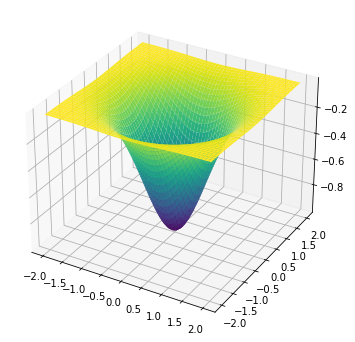

In [4]:
def plot_surf(f, **kw):
    L, n = 2, 400
    x = np.linspace(-L, L, n)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    # set up 3d plot
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': '3d'})

    Z = f([X, Y])

    ax.plot_surface(X, Y, Z, cmap="viridis", **kw)
    return ax


plot_surf(f);

As you can see from the above we have a global minimum at (0,0)

Let's define a function that can compute the gradient of our function: $$\nabla f(x) = \begin{bmatrix} -2 x_1 f(x) \\ -2 x_2 f(x) \end{bmatrix}$$

In [5]:
def df(x):
    return -2*np.asarray(x)*f(x)

And now we can use our `grad_descent` function to find the minimizer for the function `f`, given its gradient `df`:

In [6]:
trace = grad_descent(df, [2, -0.3])
opt = trace[-1]
opt

{'x': array([ 3.61638170e-04, -5.42457255e-05]),
 'i': 87,
 'err': 0.0009040951886375966}

Let's redo the surface plot, this time including a scatter chart showing the path of $x_i$ over time

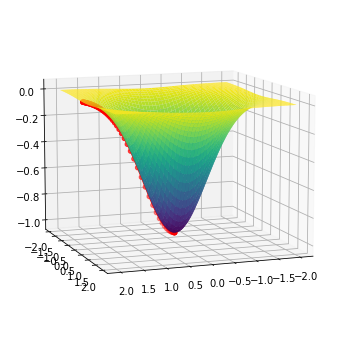

In [7]:
def get_trace_xyz(f, trace):
    xy = [i["x"] for i in trace]
    x, y = zip(*xy)
    z = f([np.array(x), np.array(y)])
    return x, y, z


def plot_path(f, trace, **kw):
    ax = plot_surf(f, **kw)
    x, y, z = get_trace_xyz(f, trace)
    ax.scatter3D(x, y, z, c="red")
    ax.plot(x, y, z, c="red")
    ax.view_init(10, 10*7)
    return ax

plot_path(f, trace);

Another very helpful way to view the algorithm's progress is with a contour plot

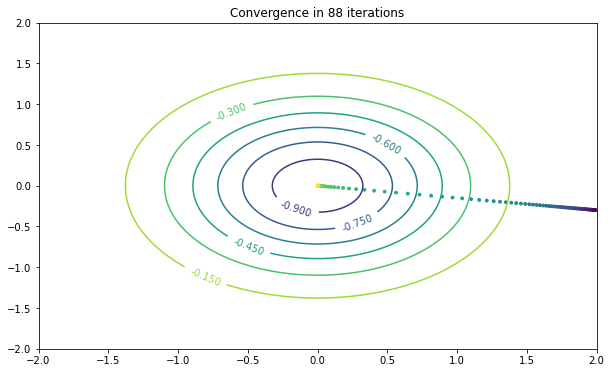

In [8]:
def plot_contour_path(f, trace, ax=None):
    L, n = 2, 400
    x = np.linspace(-L, L, n)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    Z = f([X, Y])

    # set up plot
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
    
    x, y, z = get_trace_xyz(f, trace)
    ax.scatter(x, y, c=np.linspace(0.5, 1, len(x)), s=8)
    ax.set_title("Convergence in {} iterations".format(len(x)));
    return ax

ax = plot_contour_path(f, trace);

### Importance of Learning rate

- Recall the update rule for $x$: $x_{i+1} = x_i - \alpha \nabla f(x) \big|_{x=x_i}$
- The parameter $\alpha$ is called the *learning rate*
- This influences two key features of the algorithm:
    - *rate of convergence*: how many iterations it takes to go from starting position to final position
    - *stability of iterations*: whether the problem remains well defined from one iteration to the next
- In general a smaller $\alpha$ means a slower rate of convergence, but more stable algorithm

#### Small Learning rate

- Let's see what happens as we make the learning rate very small
- By default, or `grad_descent` sets $\alpha$ = 0.1
- Let's try smaller values for $\alpha$

In [9]:
def alpha_experiment(alphas):
    N = len(alphas)
    fig, ax = plt.subplots(1, N, figsize=(N*4, 4))
    for alpha, ax in zip(alphas, ax):
        trace_alpha = grad_descent(df, [2, -0.3], alpha=alpha, T=100_000)
        plot_contour_path(f, trace_alpha, ax=ax)
    fig.tight_layout()
    return fig

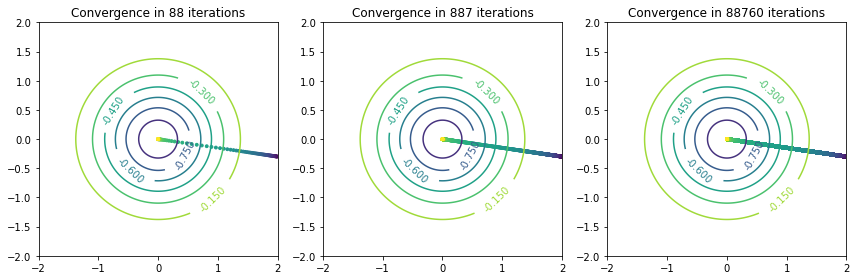

In [10]:
alpha_experiment([0.1, 0.01, 0.0001]);

- Notice how we ended up at the same place (near (0,0)), but when alpha became very small it took far more iterations
- Also notice that when the slope gets steeper (between (0, 1) for example), the steps are larger
    - This is a feature of gradient descent: when gradient is large (steep), steps are bigger
    - Easiest to see on chart where alpha = 0.1

#### Impact of high learning rate

- Let's now consider the alternative where $\alpha$ is large

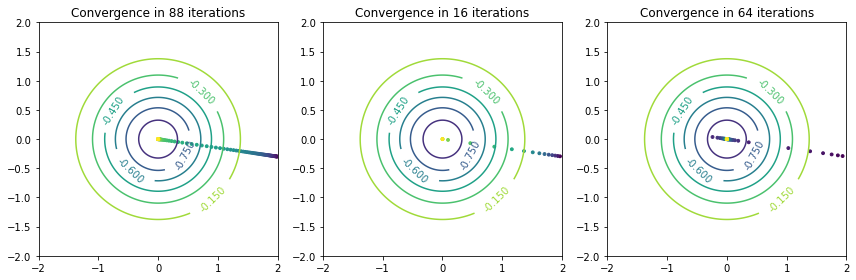

In [11]:
alpha_experiment([0.1, 0.5, 0.95]);

- Notice that with $\alpha = 0.5$ convergence was very fast -- only 16 iterations
- However, when we increase alpha further to $\alpha=0.95$ we needed 64 iterations, why?
    - Learning rate was too high and caused overshoot
    - Can think of gradient descent as rolling a marble on a surface with a "push" and a "snapshot" at fixed time intervals
        - Strength of push related to size of $\alpha$. If you push too hard, you overshoot

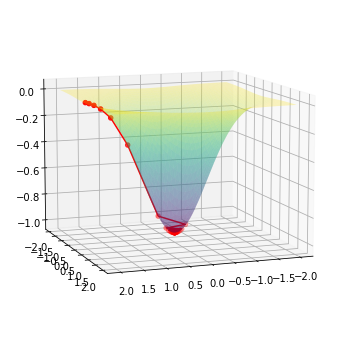

In [12]:
trace95 = grad_descent(df, [2.0, -0.3], alpha=0.95)
plot_path(f, trace95, alpha=0.3);

The problem can get worse if we make $\alpha$ too big:

In [13]:
grad_descent(df, [0.2, -0.3], alpha=1)

ValueError: Failed to converge

- In this case the iterations became unstable and the marble "escaped"
- To plot the escape we need to do a few iterations "by hand"

In [14]:
def interactive_alpha_experiment(alpha_power, T=50):
    "alpha = 10**alpha_power to make it easy to do things on log10 scale"
    x0 = np.array([2.0, -0.3])
    x = np.copy(x0)
    trace = []
    
    alpha = 10 ** alpha_power

    for i in range(T):
        df_i = df(x)
        xp = x - alpha * df_i
        err = max(abs(df_i))
        status = {"x": xp, "i": i, "err": err}
        trace.append(status)
        x[:] = xp[:]

    ax = plot_path(f, trace, alpha=0.3)
    ax.set_title(f"alpha = {alpha}")
    return ax

In [15]:
from ipywidgets import interact, widgets
interact(
    interactive_alpha_experiment, 
    alpha_power=widgets.FloatSlider(min=-3, max=3, step=0.25, value=-1),
    T=widgets.IntSlider(min=1, max=1000, step=1, value=50)
);

interactive(children=(FloatSlider(value=-1.0, description='alpha_power', max=3.0, min=-3.0, step=0.25), IntSli…

### Numerical Derivatives

- In our example above, we chose an easily differentiable function
- We will not always be fortunate enough to know the derivative of our objective function in closed form
- In these cases, the` standard approach is to approximate the derivative numerically
- The classic algorithm for numerical approximation of derivatives is called finite differencing

#### Finite Differences

- A finite difference approximation of a derivative comes directly from the definition of a derivative: $$\frac{df}{dx} = \lim_{\delta \downarrow 0} \frac{f(x + \delta) - f(x)}{\delta}$$
- In code, we can choose a value for $\delta$ that is very small -- perhaps on the order of 1e-6 -- and evaluate the fraction above
- For the gradient, we apply the finite difference approximation one element of $x$ at a time: $$\nabla f(x) \approx \begin{bmatrix}\frac{f(x + e_1 \delta) - f(x)}{\delta} \\ \frac{f(x + e_2 \delta) - f(x)}{\delta} \\ \vdots \\ \frac{f(x + e_N \delta) - f(x)}{\delta} \end{bmatrix},$$
where $e_i$ is the $i$th unit vector

In [16]:
def forward_difference(f, x, delta):
    out = np.zeros_like(x)
    fx = f(x)
    
    for i in range(len(x)):
        xi = np.copy(x)
        xi[i] += delta
        fx_i = f(xi)
        out[i] = (fx_i - fx) / delta
    
    return out

In [17]:
x0 = np.array([0.2, 0.4])
forward_difference(f, x0, 1e-5)

array([0.32749983, 0.65499017])

In [18]:
df(x0)

array([0.3274923, 0.6549846])

In [19]:
def grad_descent_finite_diff(f, x0, delta=1e-4, **kw):
    def df_fd(x):
        return forward_difference(f, x, delta=delta)
    return grad_descent(df_fd, x0, **kw)

- Let's see what happens in our example when we use numerical derivatives

In [20]:
trace_fd = grad_descent_finite_diff(f, [2, -0.3])
trace_fd[-1]

{'x': array([ 0.00031224, -0.00010431]), 'i': 87, 'err': 0.0009055958283266108}

#### Choosing $\delta$

- To use finite differencing techniques we need to choose a value for the parameter $\delta$
- In the mathematical theory, $\delta$ should approach zero to compute the exact derivative (remember the limit definition!!)
- However, computers don't do exact artithmetic
- Instead, they use floating poing approximations
- One implication of this is that dividing by a very small number (like a small $\delta$) can be highly inaccurate
- Let's explore this...

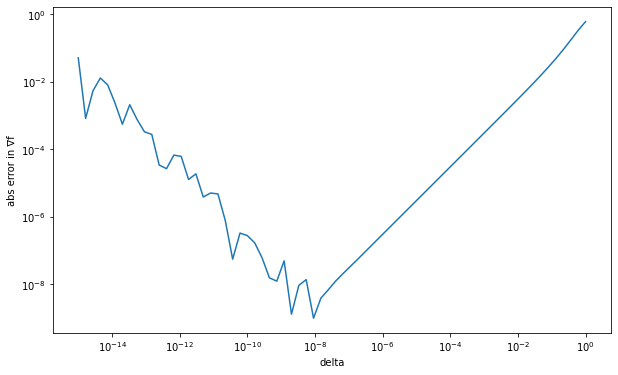

In [21]:
def plot_fd_err(f, df, x0):
    x = []
    y = []
    dfdx = df(x0)
    for delta in np.logspace(-15, 0, 70):
        approx_dfdx = forward_difference(f, x0, delta=delta)
        x.append(delta)
        y.append(max(abs(dfdx - approx_dfdx)))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(x, y)
    ax.set_xlabel("delta")
    ax.set_ylabel("abs error in ∇f")
    return ax

plot_fd_err(f, df, [0.5, -0.5]);

#### Aside: Smoothness

- The function `f` we have been working with is particularly well behaved
- Many objective functions in machine learning are not
- When we have a less smooth function, choosing $\delta$ is even more difficult and important

#### Comment on Efficiency

- Note that in order to do a finite difference approximation of the gradient we needed N+1 function calls, where $N$ is the number of elements in $x$
- This is ok when $N = 2$
- But when we do deep learning, $N$ can be the number of parameters in our model, which can be in the billions!
- Trying to do analytical (by hand) derivatives of this function is not feasible, and trying to use finite difference techniques is prohibitively costly

## Tensorflow

- Up until this point we have leaned on the numpy and pandas libraries
- They are very powerful and excellent at what they do
- However, as we build towards more computationally expensive models (like deep neural networks), we will need to power up our tools
- There are a few enterprise quality libraries specializing in this type of computation
- They are tensorflow (from Google) and pytorch (from Facebook)
- We will use tensorflow in this course

### Tensorflow Overview

- At its heart tensorflow has a few core features:
    - n-dimensional array or **tensor** (similar to numpy)
    - ability to execute on specialized hardware (like GPU or TPU)
    - rich set of functions useful for computation, machine learning, and deep learning
    - support for deploying ML models to production and running on *edge* devices
    - *automatic differentiation*
- This last point is one we'll focus on...

### Automatic Differentiation

- There are 3 ways computers can compute (or approximate) derivatives:
    1. Numerical approximation: like finite differences from above
    2. Symbolic differentiation: represent variables as symbols and use a rules engine to compute derivatives
    3. Automatic differentiation: compute *exact* derivatives *numerically*
- Various benefits of automatic differentiation
    - Efficient: same order of complexity ("big O") as evaluating the function
    - Flexible: computes derivative of what happened, allows `for`, `if`, etc.
    - Exact: not an approximation

- We will see how to use the autodiff functionality of tensorflow, but first we need to start at the basics...

In [23]:
# uncomment below to install tensorflow
%pip install tensorflow
import tensorflow as tf

     |████████████████████████████████| 217.4 MB 3.6 kB/s             
     |████████████████████████████████| 126 kB 6.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 13.0 MB 12.1 MB/s            
     |████████████████████████████████| 1.4 MB 3.1 MB/s            
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
     |████████████████████████████████| 57 kB 5.3 MB/s             
     |████████████████████████████████| 462 kB 4.9 MB/s            
     |████████████████████████████████| 65 kB 5.8 MB/s             
     |████████████████████████████████| 4.3 MB 13.7 MB/s            
     |████████████████████████████████| 1.6 MB 12.2 MB/s            
     |████████████████████████████████| 5.8 MB 23.4 MB/s            
     |████████████████████████████████| 42 kB 3.2 MB/s             
     |████████████████████████████████| 3.5 MB 8.5 MB/s            
     |████████████████████████████████| 97 kB 6.0 MB/s             
     |██████████

Many of our familiar numpy array creation funcitons have been replicated in tensorflow

In [24]:
tf.linspace(-2, 2, 21)

<tf.Tensor: shape=(21,), dtype=float64, numpy=
array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
        0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ])>

In [25]:
tf.ones((10, 10))

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [26]:
tf.zeros((2, 3, 2, 2))

<tf.Tensor: shape=(2, 3, 2, 2), dtype=float32, numpy=
array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]], dtype=float32)>

In [27]:
x1 = tf.eye(3)
x2 = tf.reshape(tf.range(1, 10, dtype="float32"), (3,3))

tf.sin(x1) + tf.exp(x2) * (x1+1) / (x2**2)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[  6.278034 ,   1.847264 ,   2.2317264],
       [  3.4123843,  12.714523 ,  11.206355 ],
       [ 22.380268 ,  46.57747  , 200.91762  ]], dtype=float32)>

- Notice above we had to be careful to specify that we wanted tensors with a floating point dtype
- Tensorflow is more *low level* than numpy is, and will sometimes require extra care with things like types

We can also mix and match numpy arrays and tensorflow tensors

In [28]:
x1np = np.eye(3)

x1np + x1

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)>

In [29]:
np.sin(x1)

array([[0.841471, 0.      , 0.      ],
       [0.      , 0.841471, 0.      ],
       [0.      , 0.      , 0.841471]], dtype=float32)

In [30]:
# we can get a numpy array  using .numpy() method
x1.numpy()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

#### Autodiff in tensorflow

- Now that we are warmed up, let's see how we can do autodiff in tensorflow
- First we need to redefine our objective function to use `tf.exp` instead of `np.exp`

In [31]:
def f_tf(x):
    return -tf.exp(-(x[0]**2 + x[1]**2))

- Then, tensorflow needs to know we would like it to track the derivatives for us
- To do this we have to create a tensorflow `Variable`
- We also need to create what is called a `GradientTape`
    - The name `Tape` comes from automatic differentiation theory, not crucial for us right now
    - The tape will record all operations that happen to `Variable`s
    - We can then differentiate values with respect to `Variable`s

In [32]:
x0_tf = tf.Variable([0.2, -0.3])

with tf.GradientTape() as tape:
    val = f_tf(x0_tf)

In [33]:
val

<tf.Tensor: shape=(), dtype=float32, numpy=-0.87809545>

In [34]:
tape.gradient(val, x0_tf)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.3512382, -0.5268573], dtype=float32)>

In [35]:
df(x0_tf)

array([ 0.3512382, -0.5268573], dtype=float32)

## Gradient Descent with Tensorflow and Autodiff

- We are now ready to put it all together and use tensorflow + autodiff to implement gradient descent

In [36]:
def grad_desc_tf(f, x0, epsilon=1e-3, T=200, alpha=0.1):
    
    trace = []
    x = tf.Variable(x0)
    for i in range(T):
        with tf.GradientTape() as tape:
            fx = f(x)
        dfdx = tape.gradient(fx, x)
        xp = x - alpha * dfdx
        err = max(abs(dfdx))
        status = dict(
            i=i, 
            fx=fx.numpy(), dfdx=dfdx.numpy(), 
            err=err.numpy(), x=x.numpy()
        )
        trace.append(status)
        if err < epsilon:
            return trace
        
        x = tf.Variable(xp)
    
    raise ValueError("No convergence")

In [37]:
trace_tf = grad_desc_tf(f_tf, [2, -0.3])
trace_tf[-1]

{'i': 87,
 'fx': -0.99999976,
 'dfdx': array([ 0.00090409, -0.00013561], dtype=float32),
 'err': 0.00090408785,
 'x': array([ 4.5204404e-04, -6.7806606e-05], dtype=float32)}

### Summary

- We learned more about the gradient descent algorithm today
- Gradient descent (and its relatives) are at the heart of many modern deep learning algorithms
- We saw the importance of the important learning rate parameter and how it relates to the rate of convergence and the stability of the algorithm
- We also learned about tensorflow and automatic differentiation
- We will continue using the gradient descent knowlege and tensorflow library as we move forward